In [1]:
import pickle
import datetime

import numpy as np

import matplotlib.pyplot as plt
from labellines import labelLine, labelLines

from centrex_tlf import states, hamiltonian, transitions, couplings, lindblad, utils
from centrex_tlf_julia_extension import lindblad_julia


c:\Users\ogras\anaconda3\envs\centrex-tlf\lib\site-packages\julia\juliainfo.py:93: UserWarning: julia warned:
The latest version of Julia in the `release` channel is 1.11.0+0.x64.w64.mingw32. You currently have `1.10.4+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.0+0.x64.w64.mingw32 and update the `release` channel to that version.
  warnings.warn("{} warned:\n{}".format(julia, stderr))


In [2]:
plt.rcParams.update({"font.size": 15})

In [5]:
trans = [
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.Q, J_ground=1, F1=1 / 2, F=0
    ),
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.Q, J_ground=1, F1=1 / 2, F=1
    ),
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.P, J_ground=3, F1=3 / 2, F=1
    ),
]

polarizations = [
    [couplings.polarization_σm, couplings.polarization_σp],
    [couplings.polarization_σm, couplings.polarization_σp],
    [couplings.polarization_σm, couplings.polarization_σp],
]

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
)


In [6]:
# ignore small decay to J=4
obe_system = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=None,
    decay_channels=None,
    Jmax_X=3,
)


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


In [7]:
odepars = lindblad_julia.odeParameters(
    Ω0="ΩQ0*variable_on_off(t, ton0, toff0, phase0)",
    ΩQ0=1 * hamiltonian.Γ,
    δ0=0.0,  # detuning of the laser [rad/s]
    P0="sin(ω0*t + φ0)",
    Pσm0="P0>0",
    Pσp0="P0<=0",
    ω0=2 * np.pi * 1e6,  # polarization switching frequency [rad/s]
    φ0=0.0,  # polarization switching phase [rad]
    Ω1="ΩQ1*variable_on_off(t, ton1, toff1, phase1)",
    ΩQ1=1 * hamiltonian.Γ,
    δ1=0.0,
    P1="sin(ω1*t + φ1)",
    Pσm1="P1>0",
    Pσp1="P1<=0",
    ω1=2 * np.pi * 1e6,  # polarization switching frequency [rad/s]
    φ1=0.0,  # polarization switching phase [rad]
    Ω2="ΩQ2*variable_on_off(t, ton2, toff2, phase2)",
    ΩQ2=1 * hamiltonian.Γ,
    δ2=0.0,
    P2="sin(ω2*t + φ2)",
    Pσm2="P2>0",
    Pσp2="P2<=0",
    ω2=2 * np.pi * 1e6,  # polarization switching frequency [rad/s]
    φ2=0.0,  # polarization switching phase [rad]
    # on/off parameters
    ton0=1e-6,
    toff0=2e-6,
    ton1=1e-6,
    toff1=2e-6,
    ton2=1e-4,
    toff2=2e-6,
    phase0=0.0,
    phase1=2 * np.pi / 3,
    phase2=4 * np.pi / 3,
)


In [8]:
# on my home pc julia only loads on the third try, use try except in while loop to
# automatically retry
import logging

counter = 0
while True:
    try:
        obe_system = lindblad_julia.setup_OBE_system_julia(
            obe_system, transition_selectors, odepars, n_procs=6
        )
    except Exception as e:
        counter += 1
        logging.warning(f"Catch exception {counter}")
        logging.error(e)
        if counter > 3:
            raise e
        continue
    break


ERROR:root:Exception 'InitError: could not load library "libamd.dll"
The specified module could not be found. 
during initialization of module SuiteSparse_jll' occurred while calling julia code:

        @everywhere begin
            using LinearAlgebra
            using Trapz
            using DifferentialEquations
        end
    
ERROR:root:Exception 'InitError: could not load library "C:\Users\ogras\.julia\artifacts\89e2de680927805ce1a0b46b9ca742383fa224e7\bin\libsundials_sunlinsolklu.dll"
The specified module could not be found. 
during initialization of module Sundials_jll' occurred while calling julia code:

        @everywhere begin
            using LinearAlgebra
            using Trapz
            using DifferentialEquations
        end
    


In [9]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="J")


,"|B, J = 1, F₁ = 1/2, F = 0>","|B, J = 1, F₁ = 1/2, F = 1>","|B, J = 2, F₁ = 3/2, F = 1>"
states,,,
"|X, J = 1>",1.0,0.999873,0.709417
"|X, J = 3>",0.0,0.000127,0.290583


In [10]:
couplings.generate_br_dataframe(
    obe_system.ground, obe_system.excited, group_ground="mF"
)


,"|B, J = 1, F₁ = 1/2, F = 0>","|B, J = 1, F₁ = 1/2, F = 1>","|B, J = 2, F₁ = 3/2, F = 1>"
states,,,
"|X, J = 1, F₁ = 1/2, F = 0>",0.000000,0.218683,0.447072
"|X, J = 1, F₁ = 1/2, F = 1>",0.747254,0.419126,0.202088
"|X, J = 1, F₁ = 3/2, F = 1>",0.252746,0.074107,0.052627
"|X, J = 1, F₁ = 3/2, F = 2>",0.000000,0.287957,0.007630
"|X, J = 3, F₁ = 5/2, F = 2>",0.000000,0.000127,0.290583


In [11]:
indices_J1 = states.QuantumSelector(
    J=1, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J3 = states.QuantumSelector(
    J=3, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_excited = states.QuantumSelector(
    electronic=states.ElectronicState.B
).get_indices(obe_system.QN)


In [12]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=1, electronic=states.ElectronicState.X),
    obe_system.QN,
)


In [27]:
odepars.ton0 = 1e-6
odepars.ton1 = 1e-6
odepars.ton2 = 1e-6
odepars.toff0 = 2e-6
odepars.toff1 = 2e-6
odepars.toff2 = 2e-6
odepars.phase0 = 0.0
odepars.phase1 = 2 * np.pi / 3
odepars.phase2 = 4 * np.pi / 3


In [28]:
save_idxs = utils.population.get_diagonal_indices_flattened(
    size=len(obe_system.QN), mode="julia"
)

# stop simulation when the molecules reach the end of the multipass

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 200e-6))
config = lindblad_julia.OBEProblemConfig(
    saveat=1e-6, reltol=1e-3, abstol=1e-7, save_everystep=True, callback=None
)


In [29]:
results = lindblad_julia.do_simulation_single(problem, config=config)


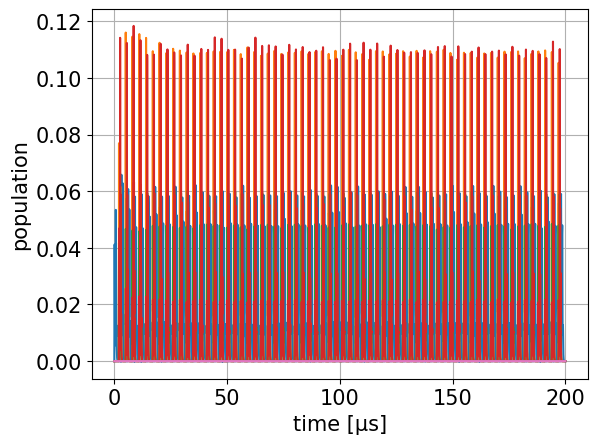

In [30]:
fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_excited].T)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

ax.grid()


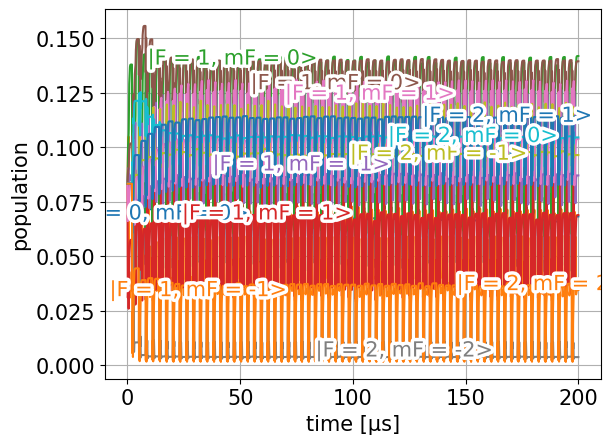

In [31]:
labels = [
    obe_system.QN[idx].largest.state_string_custom(["F", "mF"]) for idx in indices_J1
]

fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_J1].T, label=labels)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

labelLines(ax.get_lines(), zorder=2.5, align=False)

ax.grid()


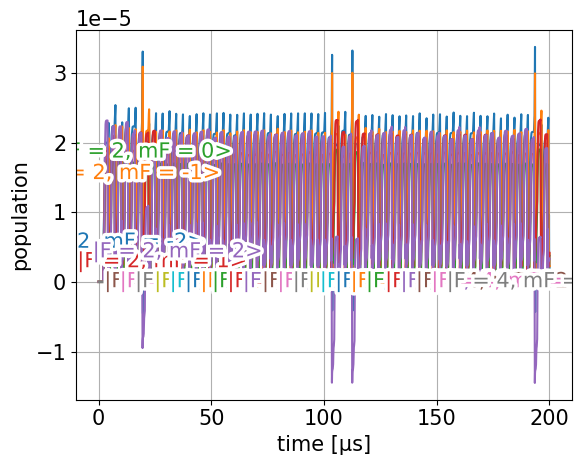

In [32]:
labels = [
    obe_system.QN[idx].largest.state_string_custom(["F", "mF"]) for idx in indices_J3
]

fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_J3].T, label=labels)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

labelLines(ax.get_lines(), zorder=2.5, align=False)

ax.grid()


In [33]:
from scipy.integrate import trapezoid

photons = (
    trapezoid(results.y[indices_excited].sum(axis=0).real, x=results.t) * hamiltonian.Γ
)

print(f"# photons = {photons:.1f}")


# photons = 61.4
